<a href="https://colab.research.google.com/github/sidijju/FastMRI/blob/master/FastMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast MRI

Scientific Research into speeding up the acquisition of MRI images via training a GAN on recovered k-space images.

### Import Required Libraries

In [1]:
!pip install dicom
!pip install tensorflow

import tensorflow as tf
import numpy as np
import dicom
import os
import numpy
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


### Retrieve Data

OASIS Data is stored in private Github repository for data privacy purposes. Running this notebook without the proper username and password will fail due to improper access. This notebook is thus just for educational purposes and cannot be run without explicit access to OASIS.

In [2]:
from getpass import getpass

user = getpass('BitBucket user')
password = getpass('BitBucket password')
os.environ['BITBUCKET_AUTH'] = user + ':' + password.replace("@", "%40")

!git clone https://$BITBUCKET_AUTH@bitbucket.org/sidijju/OASIS-Data.git
os.chdir("OASIS-Data")

BitBucket user··········
BitBucket password··········
fatal: destination path 'OASIS-Data' already exists and is not an empty directory.


In [0]:
FLAIR_DCM = []
ROI_DCM = []
T1_DCM = []
T2_DCM = []

root = "/content/OASIS-Data/BRAINIX/DICOM/"

for dirName, subdirList, fileList in os.walk("/content/OASIS-Data/BRAINIX/DICOM"):
  if(dirName == root + "FLAIR"):
    for filename in fileList:
      FLAIR_DCM.append(os.path.join(dirName,filename))
  if(dirName == root + "ROI"):
    for filename in fileList:
      ROI_DCM.append(os.path.join(dirName,filename))
  if(dirName == root + "T1"):
    for filename in fileList:
      T1_DCM.append(os.path.join(dirName,filename))
  if(dirName == root + "T2"):
    for filename in fileList:
      T2_DCM.append(os.path.join(dirName,filename))

### Read Images


In [0]:
def getInfo(ref):
  # Get ref file
  RefDs = dicom.read_file(ref[0])

  # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
  ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(ref))

  # Load spacing values (in mm)
  ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

  #calculate axes
  x = numpy.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
  y = numpy.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
  z = numpy.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])
  
  return RefDs, ConstPixelDims, ConstPixelSpacing, x, y, z

def storeList(directory, array):
  for filenameDCM in directory:
    ds = dicom.read_file(filenameDCM)
    array[:, :, int(filenameDCM[-6:-4]) - 1] = ds.pixel_array

FLAIR_Ref = getInfo(FLAIR_DCM)
FLAIR_Dicom = numpy.zeros(FLAIR_Ref[1], dtype=FLAIR_Ref[0].pixel_array.dtype)
storeList(FLAIR_DCM, FLAIR_Dicom)

ROI_Ref = getInfo(ROI_DCM)
ROI_Dicom = numpy.zeros(ROI_Ref[1], dtype=ROI_Ref[0].pixel_array.dtype)
storeList(ROI_DCM, ROI_Dicom)

T1_Ref = getInfo(T1_DCM)
T1_Dicom = numpy.zeros(T1_Ref[1], dtype=T1_Ref[0].pixel_array.dtype)
storeList(T1_DCM, T1_Dicom)

T2_Ref = getInfo(T2_DCM)
T2_Dicom = numpy.zeros(T2_Ref[1], dtype=T2_Ref[0].pixel_array.dtype)
storeList(T2_DCM, T2_Dicom)

In [0]:
def plotPictureArr(index, arr, ref, title):
  plt.axes(label = title).set_aspect('equal', 'datalim')
  plt.set_cmap(plt.gray())
  im = numpy.flipud(arr[:, :, index])
  plt.title(title)
  plt.pcolormesh(ref[3], ref[4], im)
  
def plotPicture(im, ref, title):
  plt.figure(dpi=50)
  plt.axes().set_aspect('equal', 'datalim')
  plt.set_cmap(plt.gray())
  plt.title(title)
  plt.pcolormesh(ref[3], ref[4], im)

  
def plotPictureSubplot(index, arr, ref, title, ax):
  #plt.axes(label = title).set_aspect('equal', 'datalim')
  #plt.set_cmap(plt.gray())
  im = numpy.flipud(arr[:, :, index])
  ax.set_title(title)
  ax.set_aspect('equal', 'datalim')
  ax.pcolormesh(ref[3], ref[4], im)
  

def plotSlice(slice_num):
  if(slice_num <= 21 and slice_num >= 0): #this is specific to OASIS Data
    fig, axes = plt.subplots(2, 2, sharey = True)
    fig.dpi = 100
    plt.subplots_adjust(bottom = 0.0000001)
    plt.set_cmap(plt.gray())
    plotPictureSubplot(slice_num, FLAIR_Dicom, FLAIR_Ref, "FLAIR Image Sample", axes[0,0])
    plotPictureSubplot(slice_num, ROI_Dicom, ROI_Ref, "ROI Image Sample", axes[0,1])
    plotPictureSubplot(slice_num, T1_Dicom, T1_Ref, "T1 Image Sample", axes[1,0])
    plotPictureSubplot(slice_num, T2_Dicom, T2_Ref, "T2 Image Sample", axes[1,1])
    plt.show()
  else: 
    raise Exception('Slice number should be within the interval [0 - 21]. The value of slice_num was: {}'.format(slice_num))


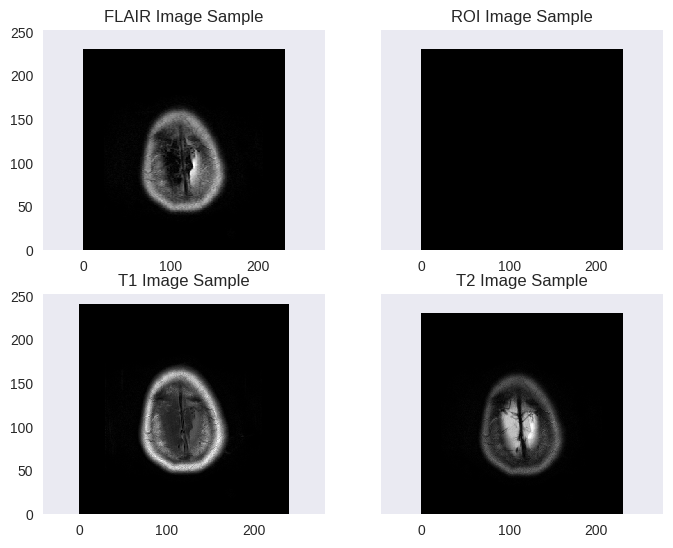

In [6]:
plotSlice(0)

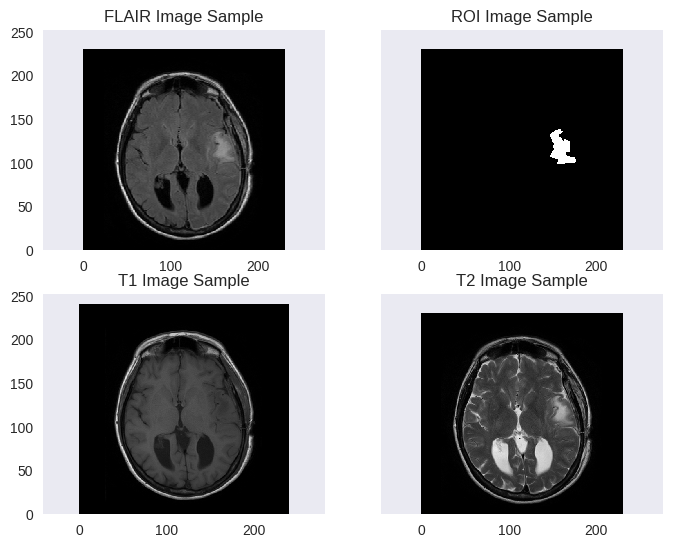

In [7]:
plotSlice(11)

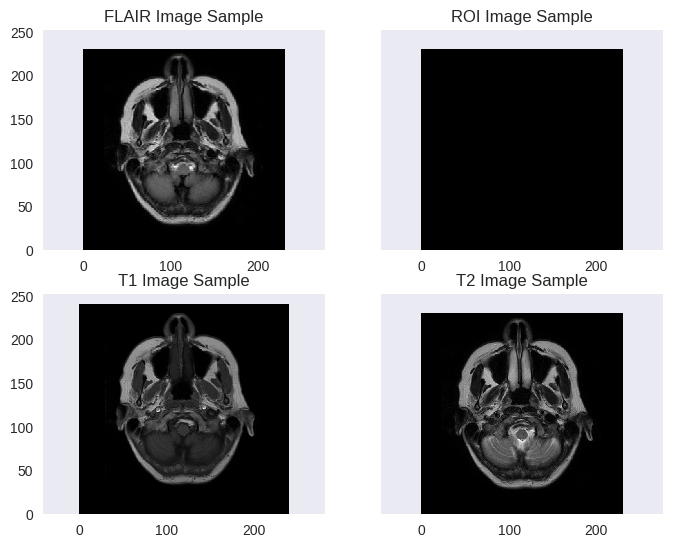

In [8]:
plotSlice(21)

## Create the DCGAN

In the following steps, we will go through the process of creating a Deep Convolutional Generative Adversarial Network (DCGAN)

### Defining Inputs

In this step, we will define the inputs for our DCGAN. A GAN usually has two models; a discriminator, which serves as a classifier to tell apart real vs generated images, and a generator, which generates images from latent noise. For our purpose, we wish to replace the latent random variable input to the generator with undersampled k-space images. 

![alt text](https://camo.githubusercontent.com/6ab92763958cbacd6cb039aca19d39f979a61bf4/687474703a2f2f7777772e74696d7a68616e6779757875616e2e636f6d2f7374617469632f696d616765732f70726f6a6563745f444347414e2f7374727563747572652e706e67)

First let's look at the image sizes of each of the modalities.

In [9]:
print("Image Size for FLAIR_DCM: " + str(getInfo(FLAIR_DCM)[1]))

print("Image Size for ROI_DCM: " + str(getInfo(ROI_DCM)[1]))

print("Image Size for T1_DCM: " + str(getInfo(T1_DCM)[1]))

print("Image Size for T2_DCM: " + str(getInfo(T2_DCM)[1]))

Image Size for FLAIR_DCM: (288, 288, 22)
Image Size for ROI_DCM: (288, 288, 22)
Image Size for T1_DCM: (512, 512, 22)
Image Size for T2_DCM: (512, 512, 22)


Let's train our first model on the T1 modality. We will only have 22 images as input.

In [0]:
IMAGE_HEIGHT = 512

IMAGE_WIDTH = 512

def model_inputs(image_width, image_height, z_dim):

  input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, 1), name='input')

  input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')

  lr = tf.placeholder(tf.float32, name='lr')
   
  return input_real, input_z, lr


### Define Networks

In the following steps, we will define the generator and discriminator networks. For now, we will use the layer structure defined in [this paper](https://arxiv.org/abs/1511.06434)



In [0]:

def discriminator(images, reuse=False):
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):

        conv1 = tf.layers.conv2d(images, 64, 5, 2, 'SAME')
        lrelu1 = tf.maximum(alpha * conv1, conv1)

        conv2 = tf.layers.conv2d(lrelu1, 128, 5, 2, 'SAME')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, 1, 'SAME')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
       
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        
        logits = tf.layers.dense(flat, 1)
        
        out = tf.sigmoid(logits)
        
        return out, logits

The generator will do the opposite of the discriminator: it will attempt to create an image from the input z. Usually this variable is simply random noise, but in our case we will use undersampled k-space derived images. 

In [0]:
def generator(z, out_channel_dim, is_train=True):
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        inputs = tf.layers.dense(z, 2*2*512)
        
        deconv2 = tf.reshape(inputs, (-1, 2, 2, 512))
        batch_norm2 = tf.layers.batch_normalization(deconv2, training=is_train)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        deconv3 = tf.layers.conv2d_transpose(lrelu2, 256, 5, 2, padding='VALID')
        batch_norm3 = tf.layers.batch_normalization(deconv3, training=is_train)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        deconv4 = tf.layers.conv2d_transpose(lrelu3, 128, 5, 2, padding='SAME')
        batch_norm4 = tf.layers.batch_normalization(deconv4, training=is_train)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
        
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 5, 2, padding='SAME')
        
        out = tf.tanh(logits)
        
        return out

### Loss Functions

A unique distinguisher about GANs is that they require three loss functions: the loss for the generator, the loss of the discriminator using real images, and the loss of the discriminator using generated images. The total loss of the discriminator is simply the sum of the losses for real and generated images.

In [0]:
def model_loss(input_real, input_z, out_channel_dim):
    
    label_smoothing = 0.9
    
    G = generator(input_z, out_channel_dim)
    D_real, D_logits_real = discriminator(input_real)
    D_gen, D_logits_gen = discriminator(G, reuse=True)
    
    #the difference in the losses is that the discriminator wants to be able to classify all the real images as 1 
    #(hence the tf.ones_like), versus classifying generated images as 0 (hence the tf.zeros_like)
    
    D_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_real,
                                                labels=tf.ones_like(D_real) * label_smoothing))
    D_loss_gen = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_gen,
                                                labels=tf.zeros_like(D_gen)))
    
    D_loss = D_loss_real + D_loss_gen
                                                  
    G_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_gen,
                                                labels=tf.ones_like(D_gen) * label_smoothing))
    
    
    return D_loss, G_loss

### Optimization

We now need to define the method in which our model will optimize the above loss functions

In [0]:
def model_opt(D_loss, G_loss, lr, beta1):
  
    T_vars = tf.trainable_variables() #gets all the variables in the scope
    thetaD = [var for var in T_vars if var.name.startswith('discriminator')]
    thetaG = [var for var in T_vars if var.name.startswith('generator')]

    # Optimize variables in each scope (generator and discriminator using the above loss functions)
    # thetaD and thetaG are the trainable parameters in the models we defined a few steps ago
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        D_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(D_loss, var_list=thetaD)
        G_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(G_loss, var_list=thetaG)

    return D_opt, G_opt

We will also need a function to display generated images created during the session

In [0]:
def show_generator_output(sess, n_images, input_z, out_channel_dim):
    z_dim = input_z.get_shape().as_list()[-1]
    ex_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: ex_z})
    
    for sample in samples:
      plt.figure()
      plt.imshow(sample[:, :, 0])
      plt.show()
      
    return sample[:, :, 0]
      

### Train the GAN

For now, we will use latent random variables for z. We will later replace this with undersampled k-space derived images.

In [0]:
def get_batches(batch_size, array):
    IMAGE_MAX_VALUE = 255
    current_index = 0
    while current_index + batch_size <= array.shape[2]:
        data_batch = array[:, :, current_index: current_index + batch_size]

        current_index += batch_size
        
        data_batch = np.rollaxis(data_batch, 2)
      
        data_batch = np.expand_dims(data_batch, axis = 4)
        
        yield data_batch / IMAGE_MAX_VALUE - 0.5

    
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape):

    input_real, input_z, _ = model_inputs(data_shape[0], data_shape[1], z_dim)
    D_loss, G_loss = model_loss(input_real, input_z, 1)
    D_opt, G_opt = model_opt(D_loss, G_loss, learning_rate, beta1)
    
    steps = 0
    
    generator_loss = []
    discriminator_loss = []
    generated_images = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size, T1_Dicom):
                
                # values range from -0.5 to 0.5, therefore scale to range -1, 1
                batch_images = batch_images * 2
                steps += 1
          
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(D_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(G_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps % 5 == 0:
                    # At the end of every 5 epochs, get the losses and print them out
                    D_loss_curr = D_loss.eval({input_z: batch_z, input_real: batch_images})
                    G_loss_curr = G_loss.eval({input_z: batch_z})
                    
                    generator_loss.append(G_loss_curr)
                    discriminator_loss.append(D_loss_curr)

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(D_loss_curr),
                          "Generator Loss: {:.4f}".format(G_loss_curr))
                    
                    generated_images.append(show_generator_output(sess, 1, input_z, 1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  # This is added back by InteractiveShellApp.init_path()


Epoch 5/1000... Discriminator Loss: 2.2503... Generator Loss: 0.3961


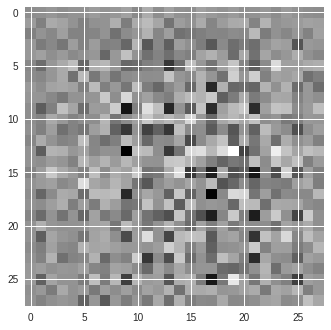

Epoch 10/1000... Discriminator Loss: 1.5923... Generator Loss: 0.5531


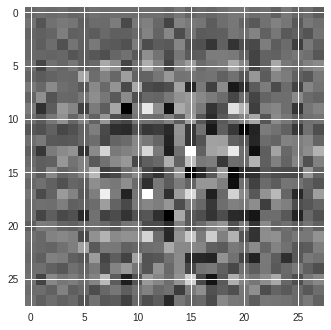

Epoch 15/1000... Discriminator Loss: 1.2430... Generator Loss: 0.7012


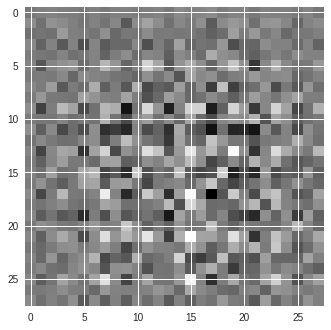

Epoch 20/1000... Discriminator Loss: 1.1359... Generator Loss: 0.7977


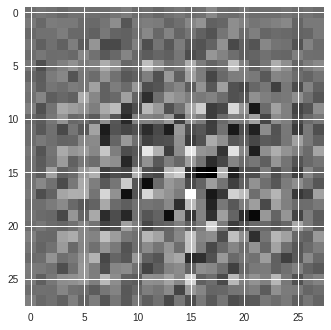

Epoch 25/1000... Discriminator Loss: 0.9939... Generator Loss: 0.9265


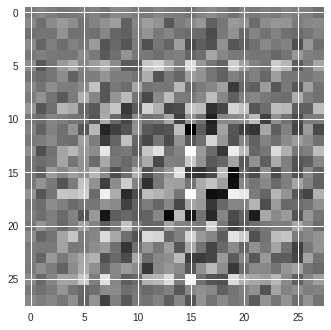

Epoch 30/1000... Discriminator Loss: 0.8915... Generator Loss: 1.0394


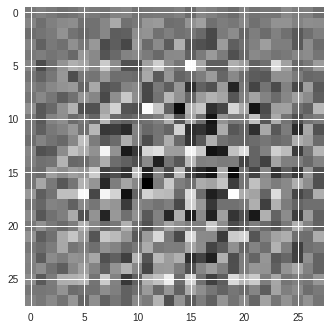

Epoch 35/1000... Discriminator Loss: 0.8434... Generator Loss: 1.1900


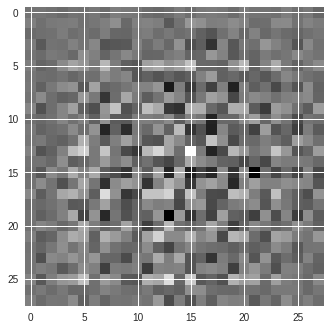

Epoch 40/1000... Discriminator Loss: 0.6939... Generator Loss: 1.3682


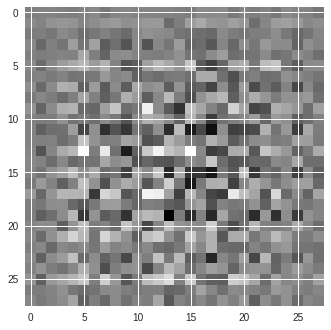

Epoch 45/1000... Discriminator Loss: 0.6891... Generator Loss: 1.4487


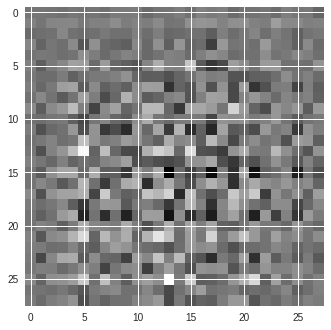

Epoch 50/1000... Discriminator Loss: 0.6552... Generator Loss: 1.4081


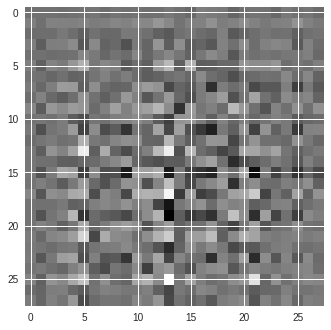

Epoch 55/1000... Discriminator Loss: 0.8166... Generator Loss: 1.4589


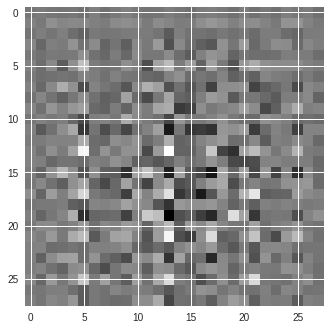

Epoch 60/1000... Discriminator Loss: 0.6330... Generator Loss: 1.4171


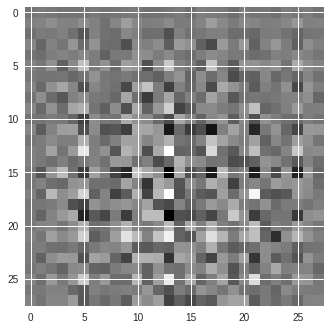

Epoch 65/1000... Discriminator Loss: 0.6191... Generator Loss: 1.6486


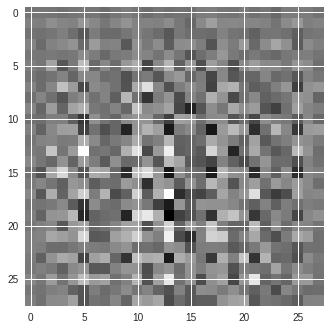

Epoch 70/1000... Discriminator Loss: 0.5931... Generator Loss: 1.5624


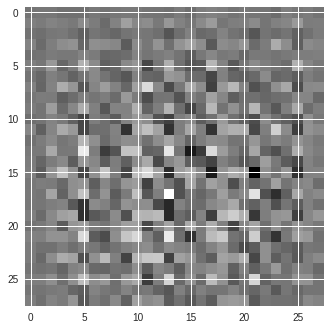

Epoch 75/1000... Discriminator Loss: 0.5568... Generator Loss: 1.8443


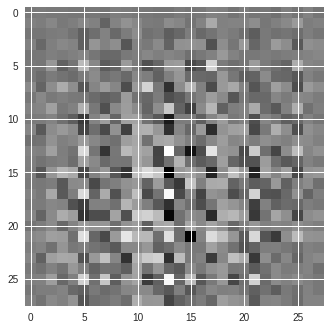

Epoch 80/1000... Discriminator Loss: 0.5402... Generator Loss: 1.7330


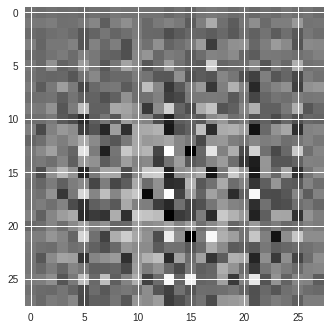

Epoch 85/1000... Discriminator Loss: 0.4827... Generator Loss: 2.0056


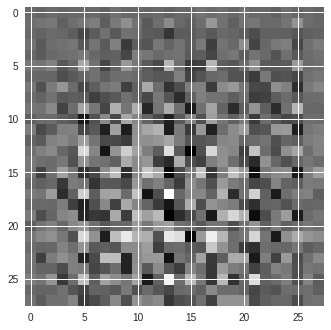

Epoch 90/1000... Discriminator Loss: 0.5090... Generator Loss: 1.9305


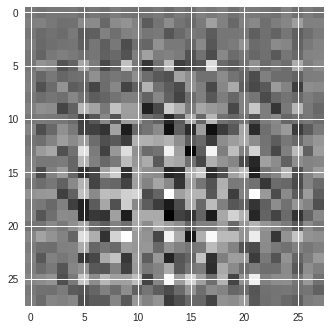

Epoch 95/1000... Discriminator Loss: 0.4690... Generator Loss: 2.0506


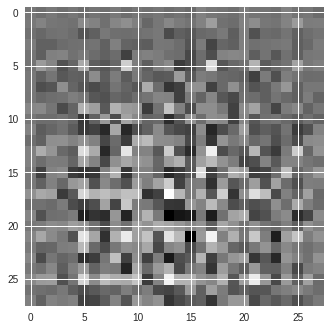

Epoch 100/1000... Discriminator Loss: 0.4566... Generator Loss: 2.1508


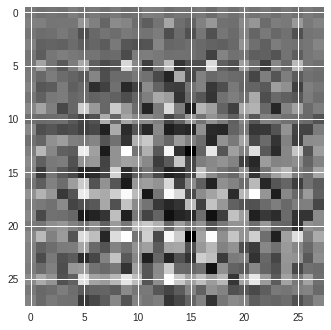

Epoch 105/1000... Discriminator Loss: 0.6456... Generator Loss: 2.0878


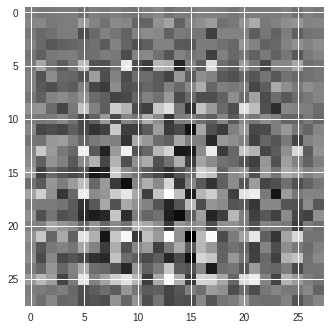

Epoch 110/1000... Discriminator Loss: 0.4569... Generator Loss: 2.1097


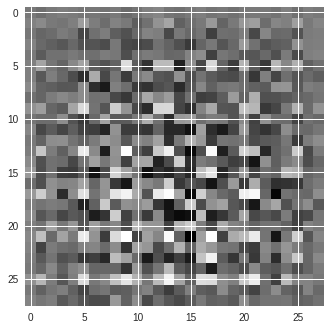

Epoch 115/1000... Discriminator Loss: 0.4297... Generator Loss: 2.4064


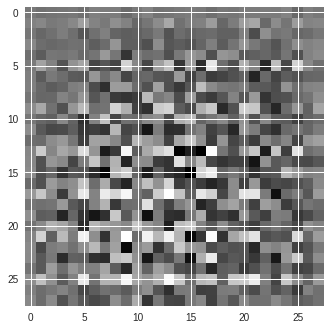

Epoch 120/1000... Discriminator Loss: 0.4392... Generator Loss: 2.2629


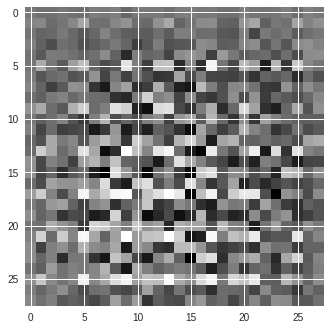

Epoch 125/1000... Discriminator Loss: 0.4150... Generator Loss: 2.4499


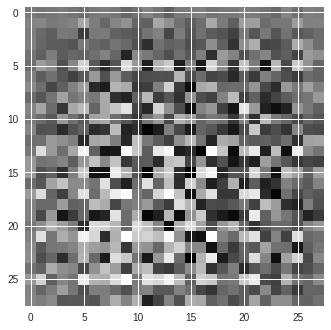

Epoch 130/1000... Discriminator Loss: 0.5016... Generator Loss: 2.5135


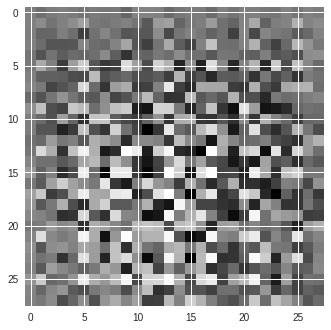

Epoch 135/1000... Discriminator Loss: 0.5342... Generator Loss: 2.0370


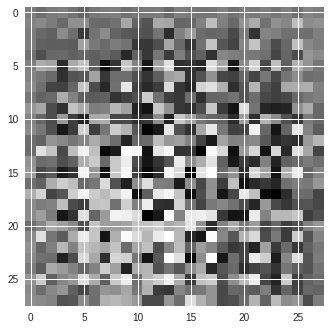

Epoch 140/1000... Discriminator Loss: 0.4292... Generator Loss: 2.3273


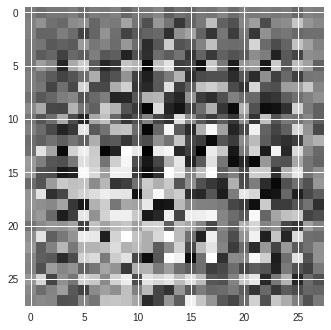

Epoch 145/1000... Discriminator Loss: 0.4014... Generator Loss: 2.5887


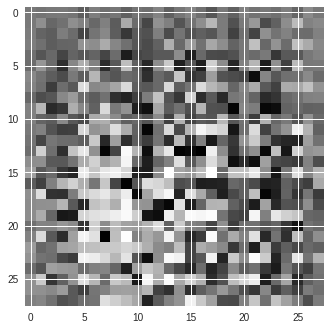

Epoch 150/1000... Discriminator Loss: 0.4300... Generator Loss: 2.6102


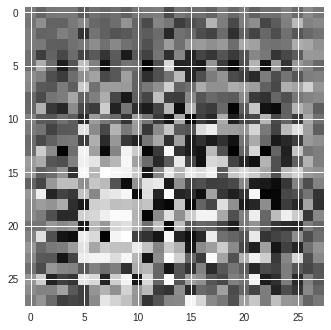

Epoch 155/1000... Discriminator Loss: 0.4287... Generator Loss: 2.3920


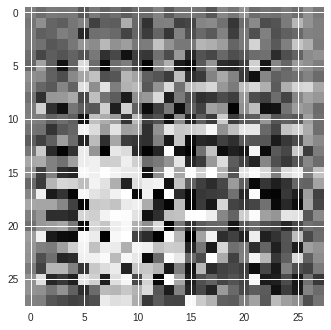

Epoch 160/1000... Discriminator Loss: 0.3943... Generator Loss: 2.6400


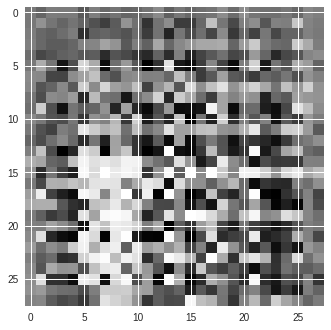

Epoch 165/1000... Discriminator Loss: 0.3878... Generator Loss: 2.7748


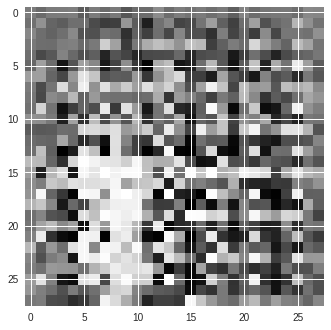

Epoch 170/1000... Discriminator Loss: 0.3857... Generator Loss: 3.0042


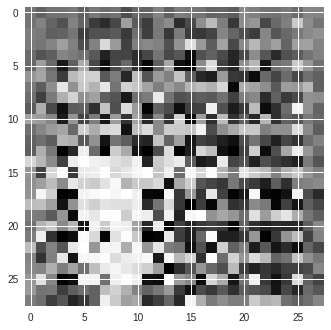

Epoch 175/1000... Discriminator Loss: 0.3858... Generator Loss: 2.8261


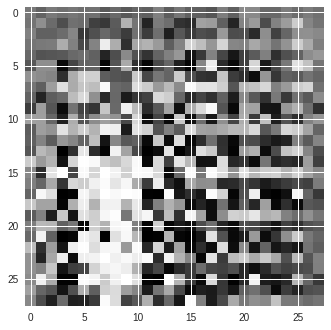

Epoch 180/1000... Discriminator Loss: 0.3767... Generator Loss: 2.9339


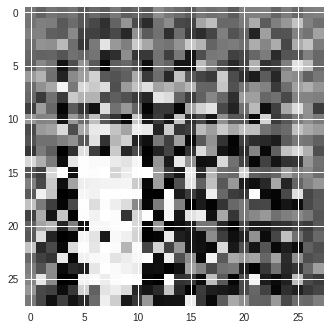

Epoch 185/1000... Discriminator Loss: 0.4591... Generator Loss: 3.0116


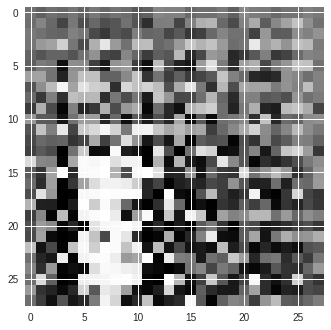

Epoch 190/1000... Discriminator Loss: 0.4095... Generator Loss: 2.5595


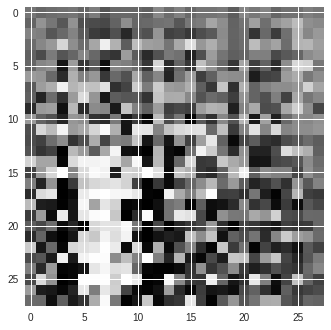

Epoch 195/1000... Discriminator Loss: 0.3769... Generator Loss: 2.9604


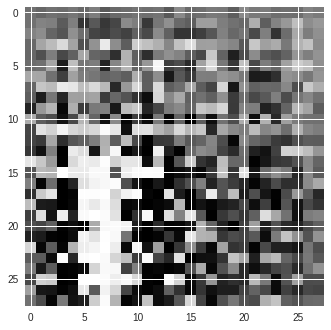

Epoch 200/1000... Discriminator Loss: 0.3639... Generator Loss: 3.1954


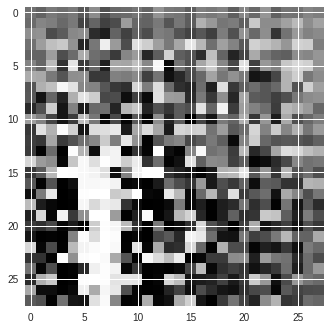

Epoch 205/1000... Discriminator Loss: 0.4958... Generator Loss: 3.1343


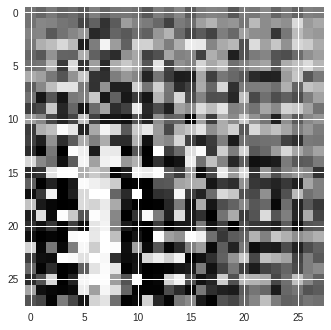

Epoch 210/1000... Discriminator Loss: 0.3852... Generator Loss: 2.8321


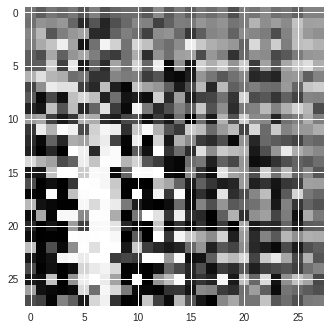

Epoch 215/1000... Discriminator Loss: 0.3737... Generator Loss: 2.9673


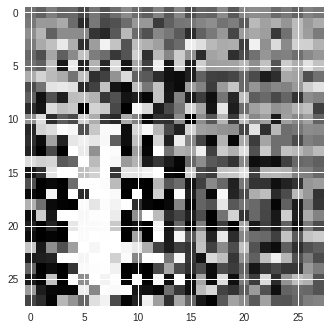

Epoch 220/1000... Discriminator Loss: 0.3615... Generator Loss: 3.2797


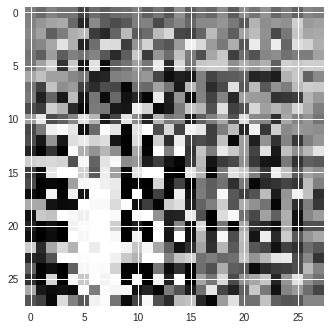

Epoch 225/1000... Discriminator Loss: 0.3744... Generator Loss: 3.3337


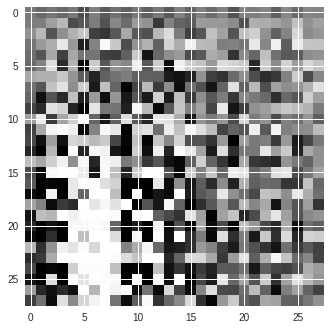

Epoch 230/1000... Discriminator Loss: 0.3710... Generator Loss: 3.2471


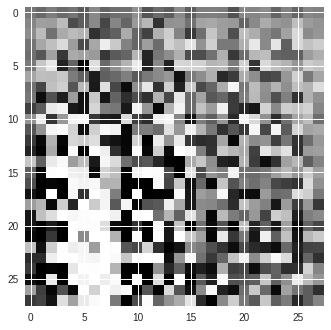

Epoch 235/1000... Discriminator Loss: 0.3610... Generator Loss: 3.2883


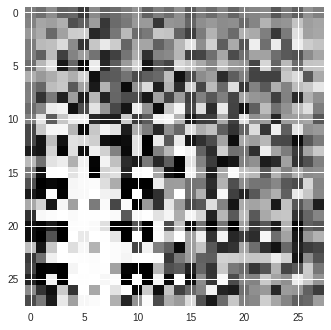

Epoch 240/1000... Discriminator Loss: 0.3549... Generator Loss: 3.4875


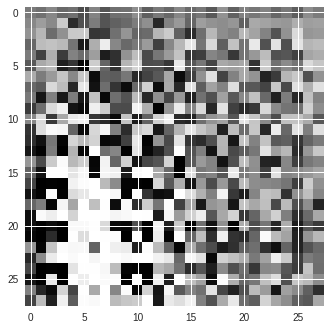

Epoch 245/1000... Discriminator Loss: 0.3588... Generator Loss: 3.4783


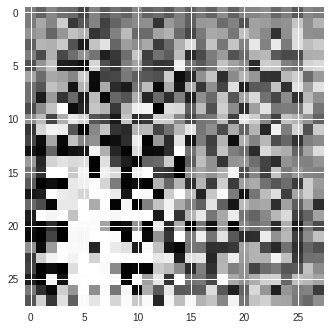

Epoch 250/1000... Discriminator Loss: 0.4376... Generator Loss: 3.2338


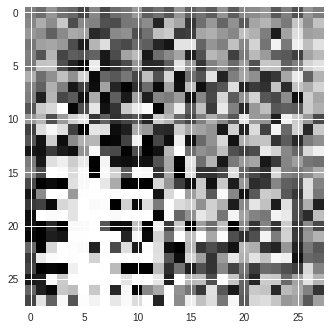

Epoch 255/1000... Discriminator Loss: 0.5170... Generator Loss: 2.9179


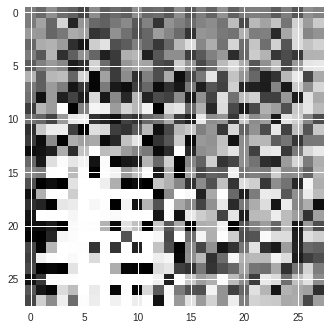

Epoch 260/1000... Discriminator Loss: 0.4053... Generator Loss: 3.0767


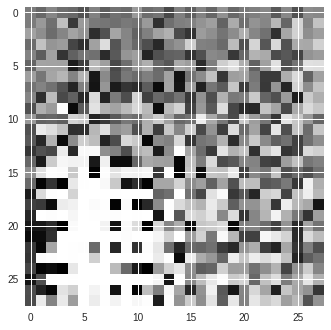

Epoch 265/1000... Discriminator Loss: 0.3592... Generator Loss: 3.3617


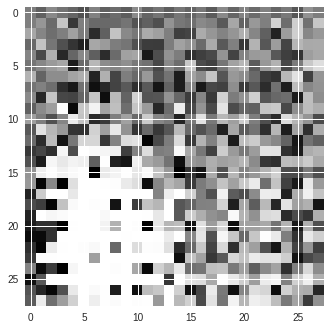

Epoch 270/1000... Discriminator Loss: 0.3543... Generator Loss: 3.4846


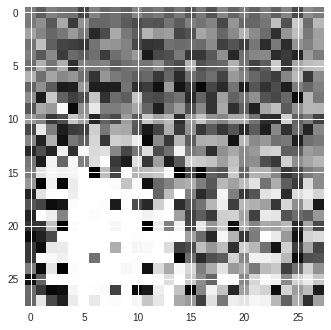

Epoch 275/1000... Discriminator Loss: 0.3568... Generator Loss: 3.6142


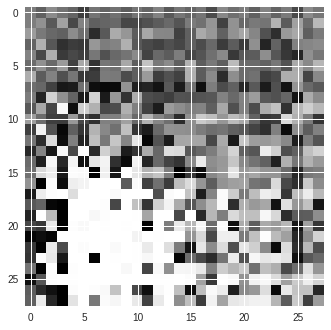

Epoch 280/1000... Discriminator Loss: 0.5852... Generator Loss: 3.2101


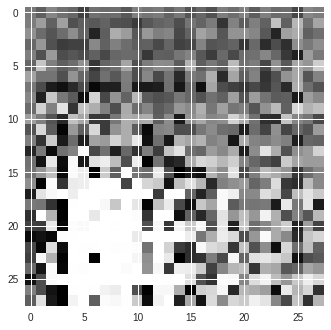

Epoch 285/1000... Discriminator Loss: 2.4672... Generator Loss: 2.9181


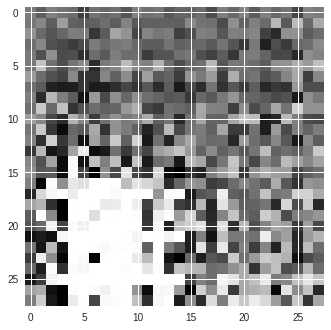

Epoch 290/1000... Discriminator Loss: 0.6373... Generator Loss: 1.6156


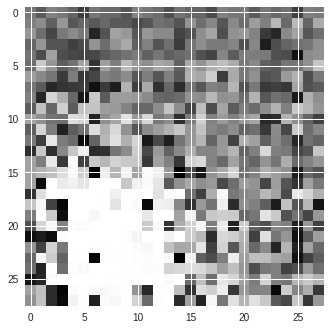

Epoch 295/1000... Discriminator Loss: 0.4741... Generator Loss: 2.1464


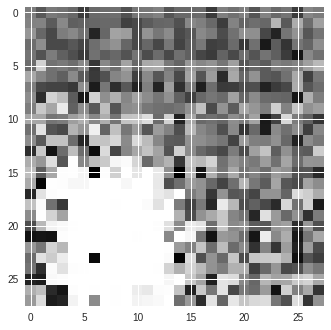

Epoch 300/1000... Discriminator Loss: 0.4343... Generator Loss: 2.4179


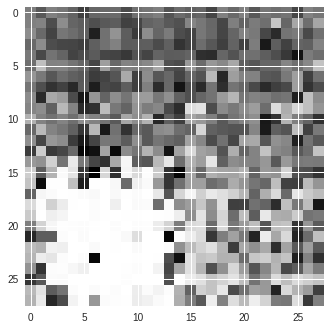

Epoch 305/1000... Discriminator Loss: 0.6885... Generator Loss: 2.3922


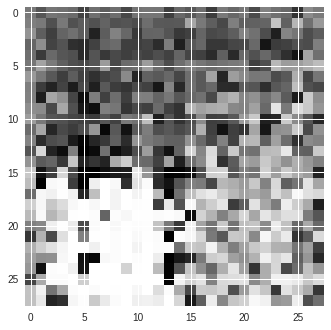

Epoch 310/1000... Discriminator Loss: 0.4410... Generator Loss: 2.4221


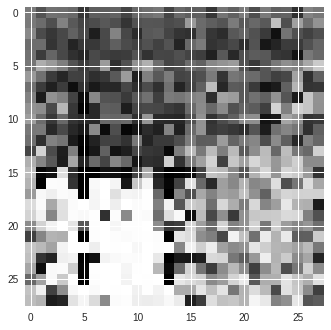

Epoch 315/1000... Discriminator Loss: 0.4259... Generator Loss: 2.4999


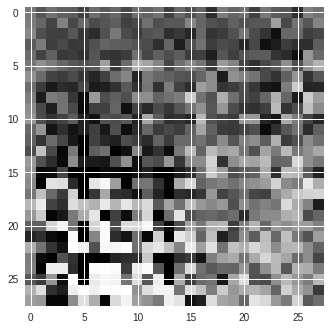

Epoch 320/1000... Discriminator Loss: 0.4101... Generator Loss: 2.6868


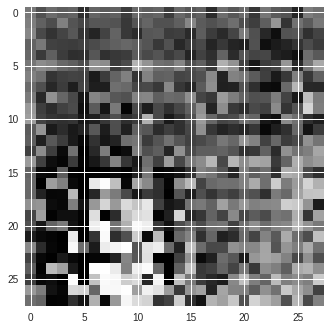

Epoch 325/1000... Discriminator Loss: 0.4792... Generator Loss: 2.4808


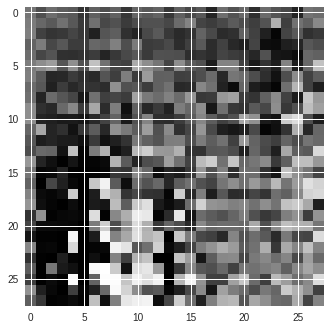

Epoch 330/1000... Discriminator Loss: 0.4510... Generator Loss: 2.5701


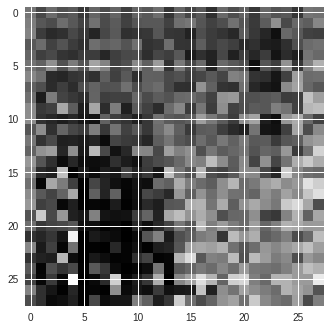

Epoch 335/1000... Discriminator Loss: 0.4135... Generator Loss: 2.6943


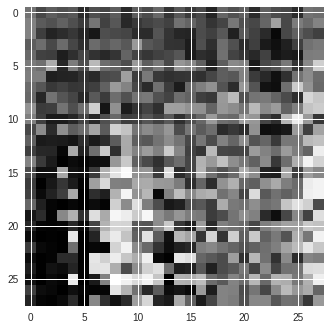

Epoch 340/1000... Discriminator Loss: 0.4564... Generator Loss: 2.6064


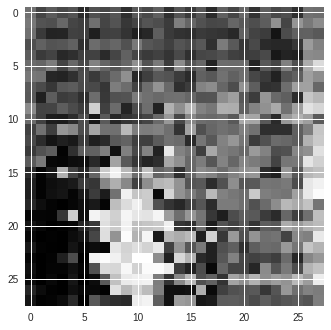

Epoch 345/1000... Discriminator Loss: 0.4005... Generator Loss: 2.7371


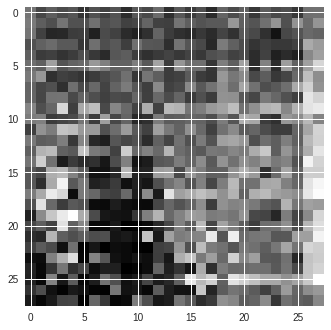

Epoch 350/1000... Discriminator Loss: 0.3992... Generator Loss: 2.6368


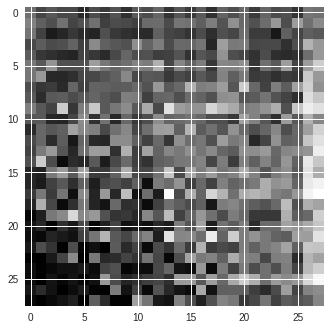

Epoch 355/1000... Discriminator Loss: 0.4405... Generator Loss: 2.8622


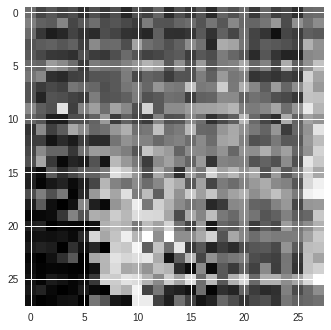

Epoch 360/1000... Discriminator Loss: 0.5289... Generator Loss: 2.0873


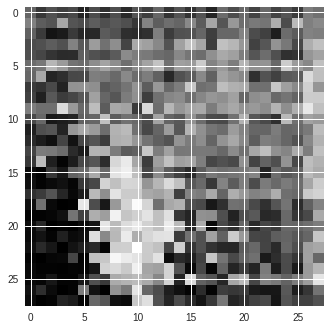

Epoch 365/1000... Discriminator Loss: 0.4697... Generator Loss: 2.3900


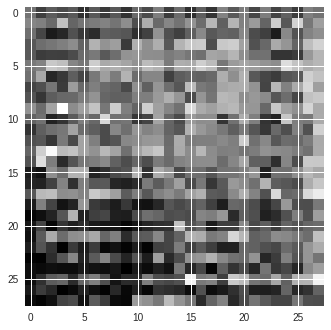

Epoch 370/1000... Discriminator Loss: 0.4097... Generator Loss: 2.5489


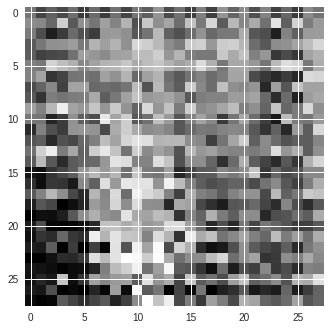

Epoch 375/1000... Discriminator Loss: 0.4033... Generator Loss: 2.5818


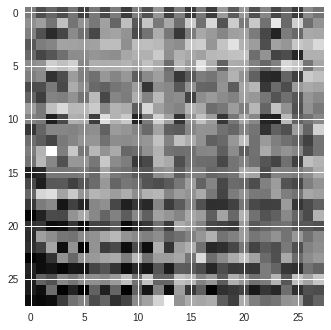

Epoch 380/1000... Discriminator Loss: 0.3907... Generator Loss: 2.7646


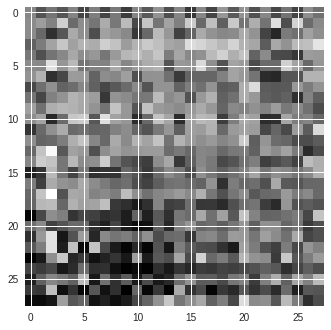

Epoch 385/1000... Discriminator Loss: 0.3716... Generator Loss: 3.1098


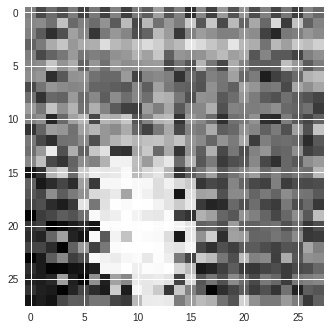

Epoch 390/1000... Discriminator Loss: 0.4014... Generator Loss: 2.7166


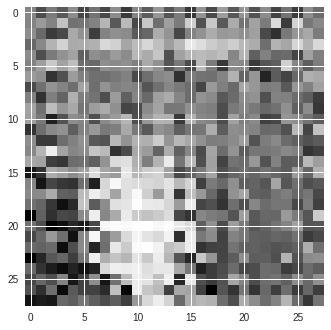

Epoch 395/1000... Discriminator Loss: 0.4059... Generator Loss: 2.8131


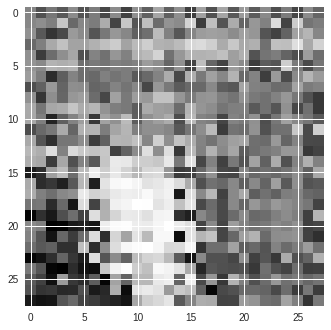

Epoch 400/1000... Discriminator Loss: 0.3833... Generator Loss: 3.1750


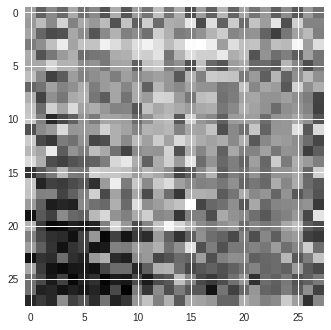

Epoch 405/1000... Discriminator Loss: 0.3765... Generator Loss: 3.0161


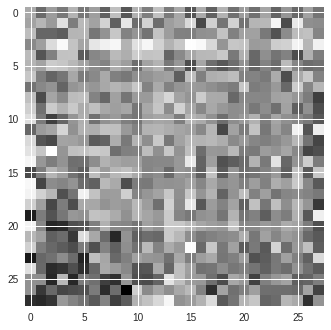

Epoch 410/1000... Discriminator Loss: 1.3552... Generator Loss: 2.5653


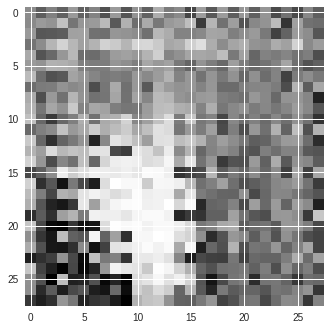

Epoch 415/1000... Discriminator Loss: 0.5060... Generator Loss: 2.1984


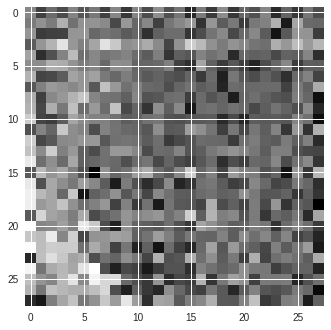

Epoch 420/1000... Discriminator Loss: 0.9654... Generator Loss: 2.7941


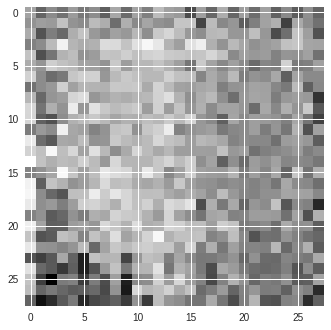

Epoch 425/1000... Discriminator Loss: 0.4589... Generator Loss: 2.4206


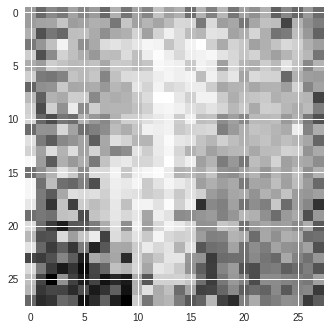

Epoch 430/1000... Discriminator Loss: 0.4082... Generator Loss: 2.8111


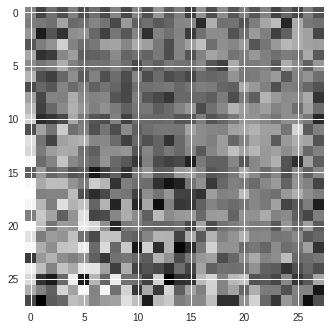

Epoch 435/1000... Discriminator Loss: 0.3979... Generator Loss: 2.8224


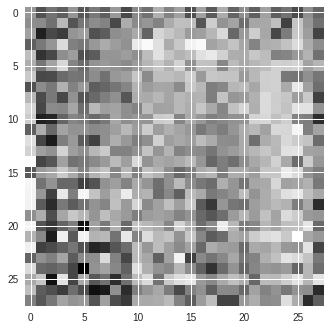

Epoch 440/1000... Discriminator Loss: 0.4337... Generator Loss: 2.7820


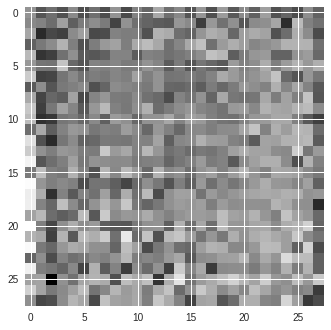

Epoch 445/1000... Discriminator Loss: 0.4139... Generator Loss: 2.5908


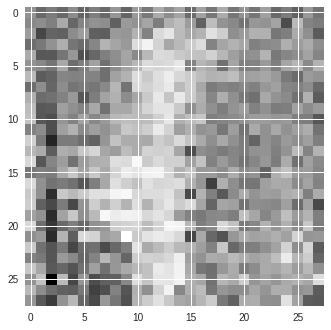

Epoch 450/1000... Discriminator Loss: 0.3804... Generator Loss: 2.9173


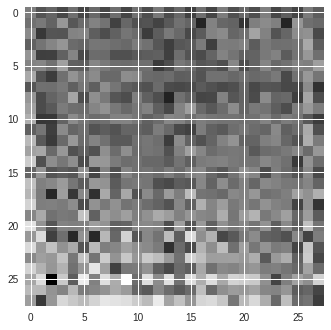

Epoch 455/1000... Discriminator Loss: 0.3743... Generator Loss: 3.0166


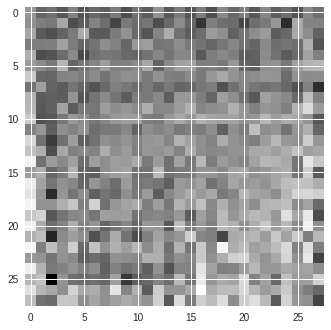

Epoch 460/1000... Discriminator Loss: 0.3865... Generator Loss: 2.8303


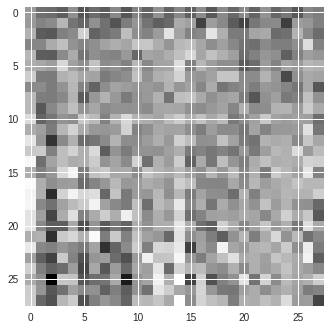

Epoch 465/1000... Discriminator Loss: 0.3542... Generator Loss: 3.6531


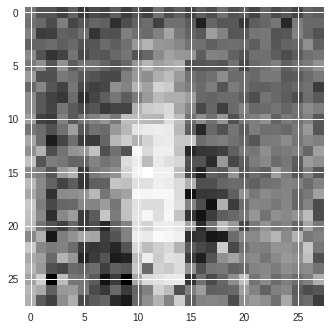

Epoch 470/1000... Discriminator Loss: 0.3596... Generator Loss: 3.4791


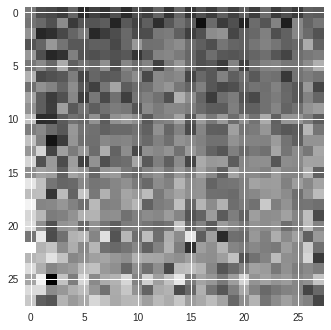

Epoch 475/1000... Discriminator Loss: 0.3631... Generator Loss: 3.3020


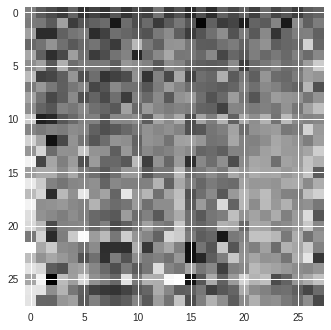

Epoch 480/1000... Discriminator Loss: 0.3613... Generator Loss: 3.5260


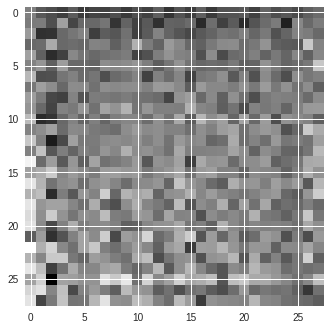

Epoch 485/1000... Discriminator Loss: 0.3849... Generator Loss: 2.9870


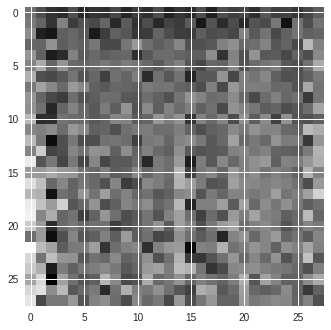

Epoch 490/1000... Discriminator Loss: 0.3749... Generator Loss: 3.0699


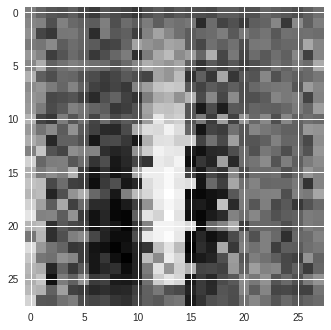

Epoch 495/1000... Discriminator Loss: 0.4175... Generator Loss: 3.5625


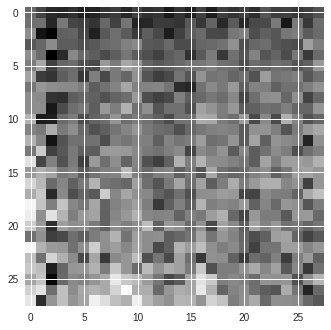

Epoch 500/1000... Discriminator Loss: 0.8975... Generator Loss: 3.3353


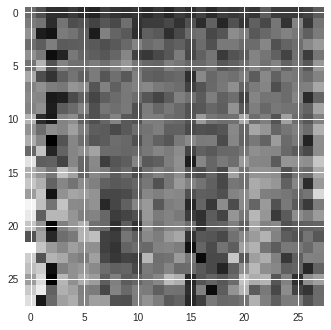

Epoch 505/1000... Discriminator Loss: 0.5035... Generator Loss: 2.9264


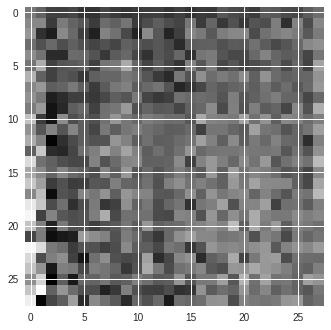

Epoch 510/1000... Discriminator Loss: 0.3784... Generator Loss: 3.3208


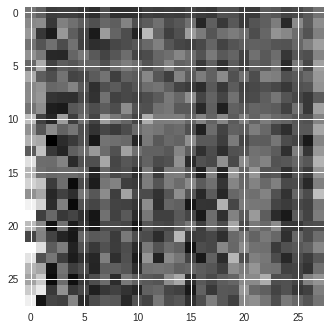

Epoch 515/1000... Discriminator Loss: 0.3635... Generator Loss: 3.4120


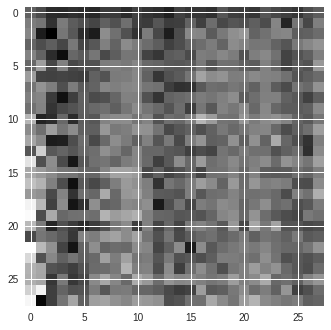

Epoch 520/1000... Discriminator Loss: 0.3501... Generator Loss: 3.8523


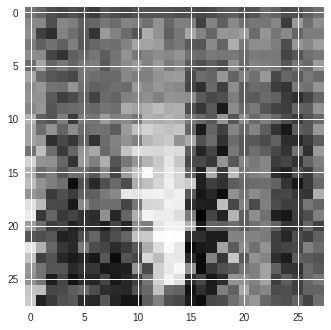

Epoch 525/1000... Discriminator Loss: 0.3524... Generator Loss: 3.6002


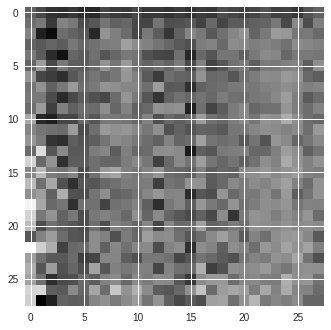

Epoch 530/1000... Discriminator Loss: 0.3554... Generator Loss: 3.5072


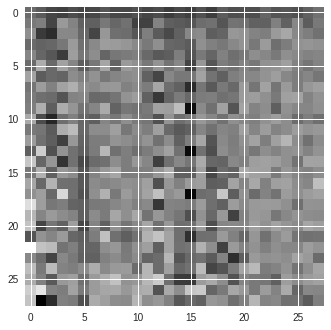

Epoch 535/1000... Discriminator Loss: 0.3507... Generator Loss: 3.6868


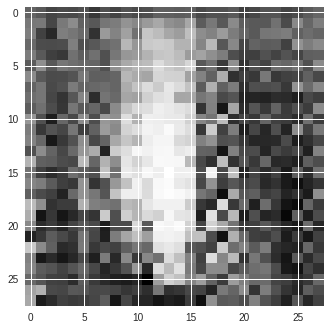

Epoch 540/1000... Discriminator Loss: 0.3506... Generator Loss: 3.7233


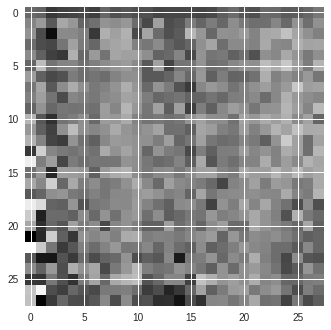

Epoch 545/1000... Discriminator Loss: 0.3525... Generator Loss: 3.6619


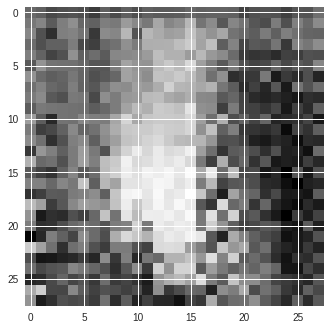

Epoch 550/1000... Discriminator Loss: 0.3519... Generator Loss: 3.6275


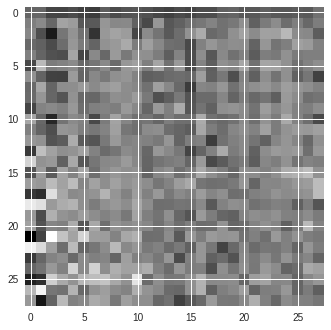

Epoch 555/1000... Discriminator Loss: 0.3489... Generator Loss: 3.7854


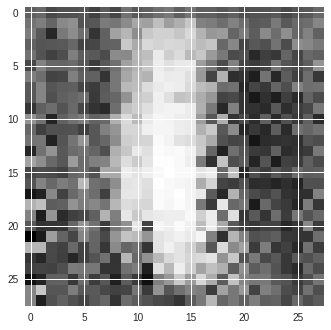

Epoch 560/1000... Discriminator Loss: 0.3470... Generator Loss: 3.9194


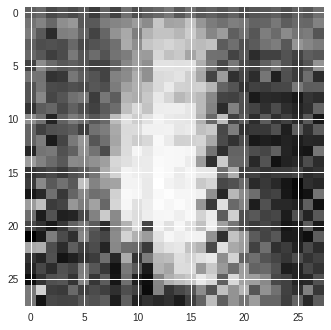

Epoch 565/1000... Discriminator Loss: 0.3491... Generator Loss: 3.7847


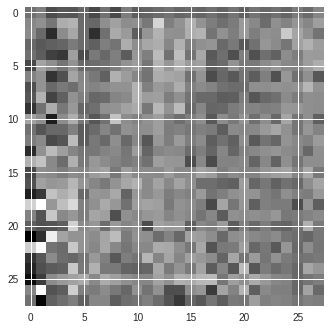

Epoch 570/1000... Discriminator Loss: 0.3435... Generator Loss: 4.0387


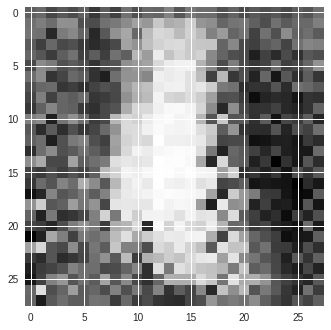

Epoch 575/1000... Discriminator Loss: 0.3471... Generator Loss: 3.8194


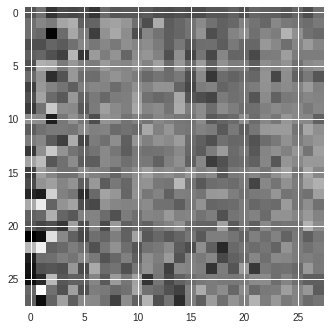

Epoch 580/1000... Discriminator Loss: 0.3511... Generator Loss: 3.7940


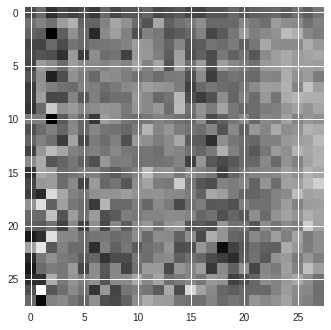

Epoch 585/1000... Discriminator Loss: 0.3475... Generator Loss: 4.1336


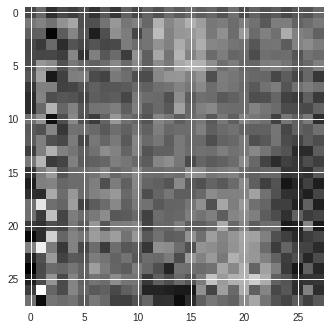

Epoch 590/1000... Discriminator Loss: 0.3423... Generator Loss: 4.0762


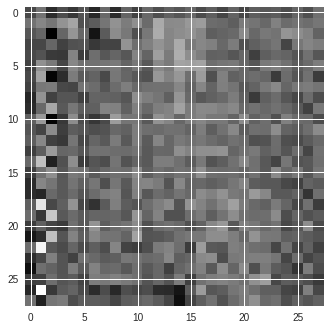

Epoch 595/1000... Discriminator Loss: 0.3456... Generator Loss: 3.8930


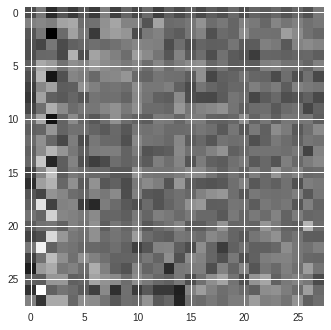

Epoch 600/1000... Discriminator Loss: 0.3404... Generator Loss: 4.2176


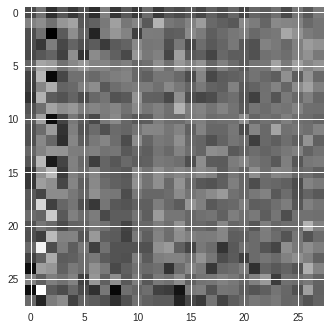

Epoch 605/1000... Discriminator Loss: 0.3407... Generator Loss: 4.1949


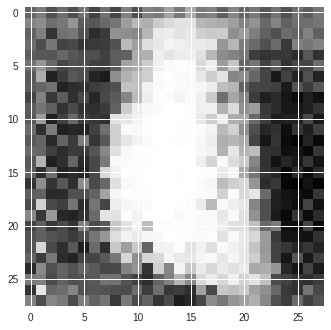

Epoch 610/1000... Discriminator Loss: 0.3419... Generator Loss: 4.1182


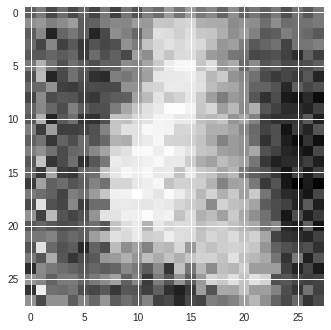

Epoch 615/1000... Discriminator Loss: 0.3474... Generator Loss: 4.0942


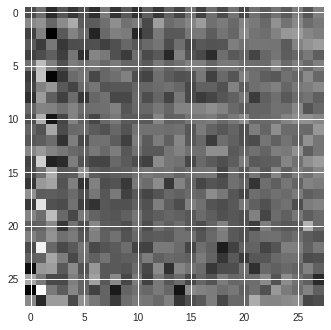

Epoch 620/1000... Discriminator Loss: 0.3404... Generator Loss: 4.4154


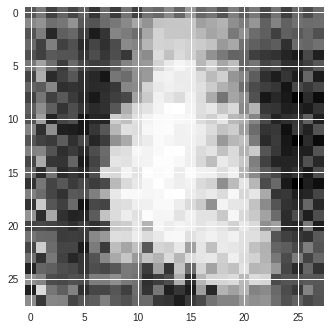

Epoch 625/1000... Discriminator Loss: 0.3390... Generator Loss: 4.3129


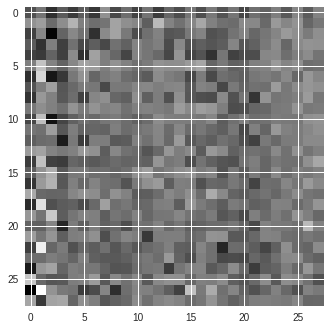

Epoch 630/1000... Discriminator Loss: 0.3406... Generator Loss: 4.3270


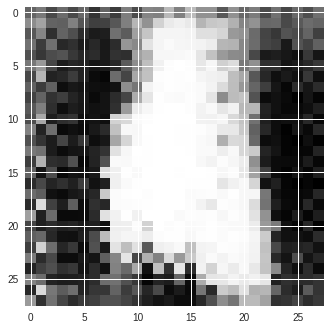

Epoch 635/1000... Discriminator Loss: 0.6660... Generator Loss: 4.2878


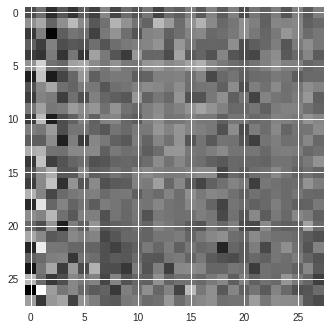

Epoch 640/1000... Discriminator Loss: 0.7582... Generator Loss: 2.7511


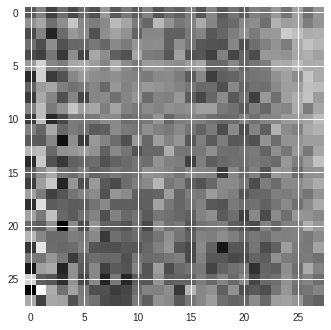

Epoch 645/1000... Discriminator Loss: 0.4759... Generator Loss: 2.4921


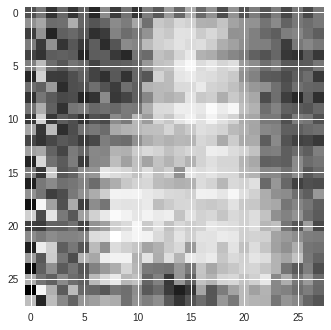

Epoch 650/1000... Discriminator Loss: 0.3732... Generator Loss: 3.2201


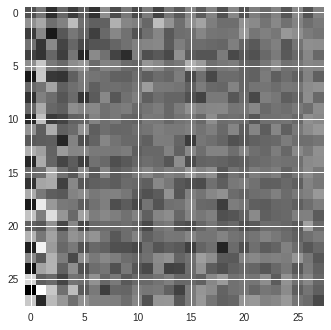

Epoch 655/1000... Discriminator Loss: 0.3551... Generator Loss: 3.5605


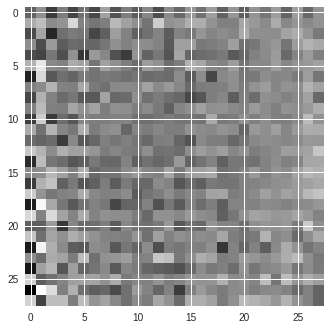

Epoch 660/1000... Discriminator Loss: 0.3457... Generator Loss: 3.9512


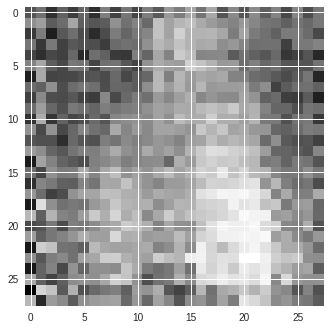

Epoch 665/1000... Discriminator Loss: 0.3485... Generator Loss: 3.8285


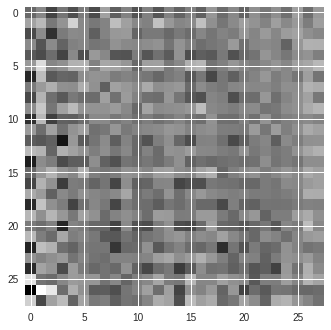

Epoch 670/1000... Discriminator Loss: 0.3465... Generator Loss: 3.8463


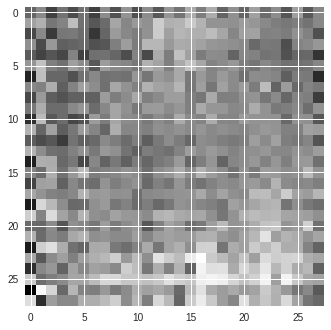

Epoch 675/1000... Discriminator Loss: 0.3419... Generator Loss: 4.1145


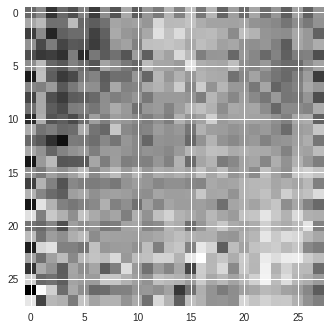

Epoch 680/1000... Discriminator Loss: 0.3431... Generator Loss: 4.0316


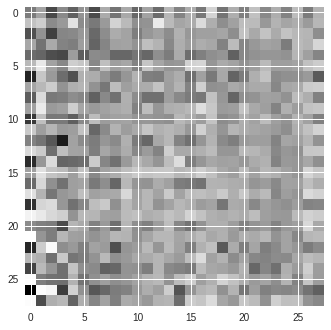

Epoch 685/1000... Discriminator Loss: 0.3398... Generator Loss: 4.2744


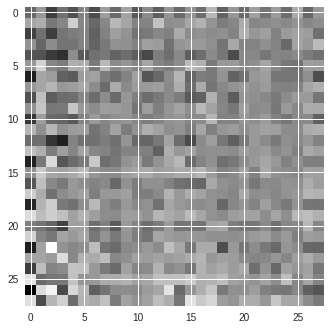

Epoch 690/1000... Discriminator Loss: 0.3400... Generator Loss: 4.2197


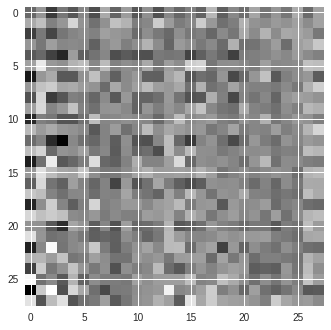

Epoch 695/1000... Discriminator Loss: 0.3412... Generator Loss: 4.1346


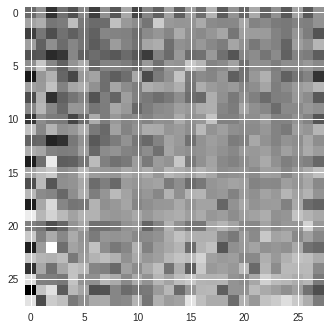

Epoch 700/1000... Discriminator Loss: 0.3386... Generator Loss: 4.4006


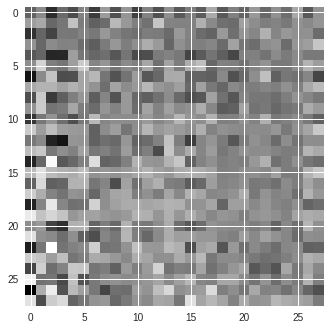

Epoch 705/1000... Discriminator Loss: 0.3411... Generator Loss: 4.2923


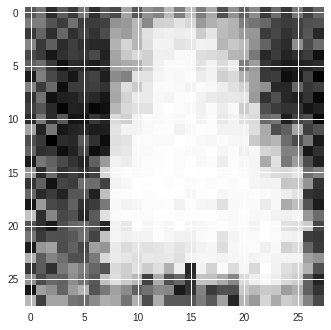

Epoch 710/1000... Discriminator Loss: 0.3372... Generator Loss: 4.5065


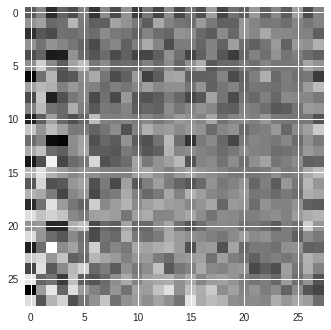

Epoch 715/1000... Discriminator Loss: 0.3369... Generator Loss: 4.6274


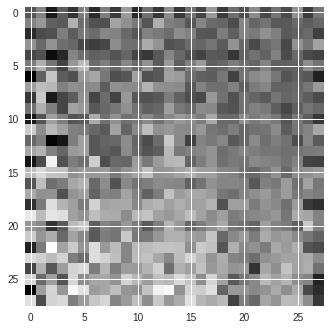

Epoch 720/1000... Discriminator Loss: 0.3410... Generator Loss: 4.4863


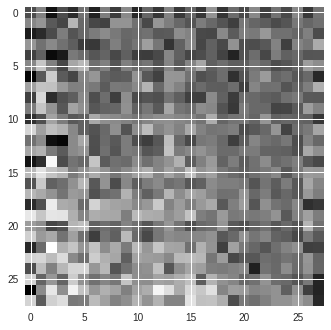

Epoch 725/1000... Discriminator Loss: 0.3387... Generator Loss: 4.4442


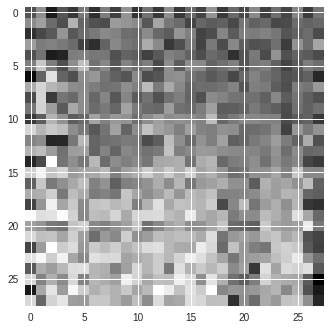

Epoch 730/1000... Discriminator Loss: 0.3389... Generator Loss: 4.3999


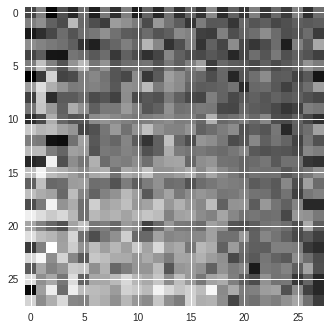

Epoch 735/1000... Discriminator Loss: 0.3415... Generator Loss: 4.2839


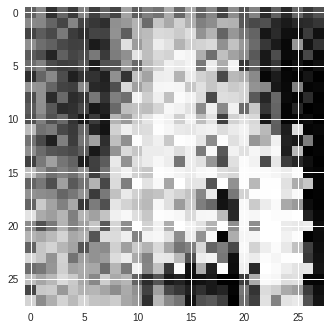

Epoch 740/1000... Discriminator Loss: 0.3416... Generator Loss: 4.2531


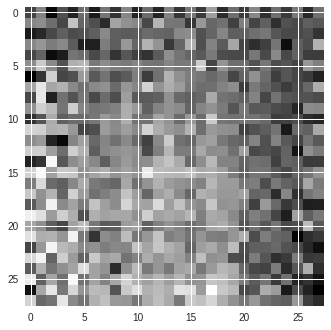

Epoch 745/1000... Discriminator Loss: 0.3441... Generator Loss: 4.1929


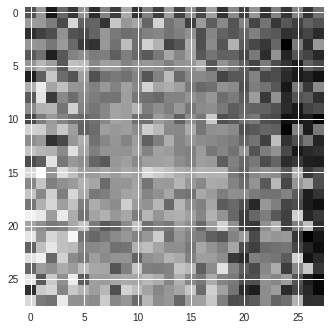

Epoch 750/1000... Discriminator Loss: 0.3415... Generator Loss: 4.1436


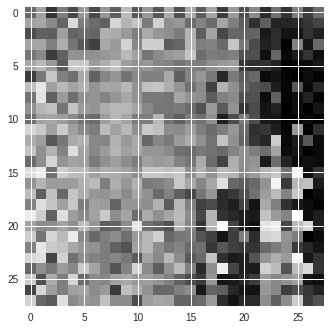

Epoch 755/1000... Discriminator Loss: 0.3395... Generator Loss: 4.2709


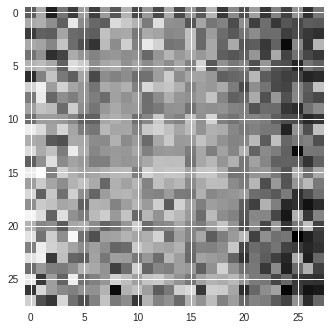

Epoch 760/1000... Discriminator Loss: 0.3520... Generator Loss: 4.2436


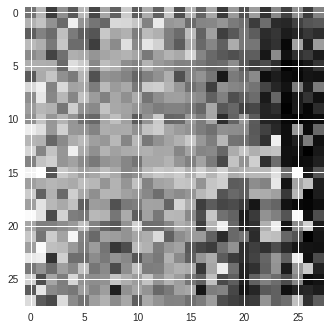

Epoch 765/1000... Discriminator Loss: 0.3404... Generator Loss: 4.2514


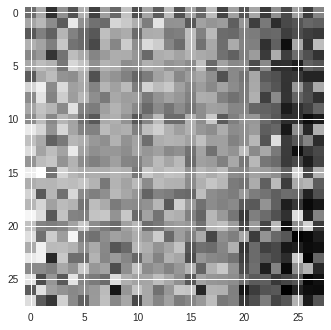

Epoch 770/1000... Discriminator Loss: 0.3390... Generator Loss: 4.3274


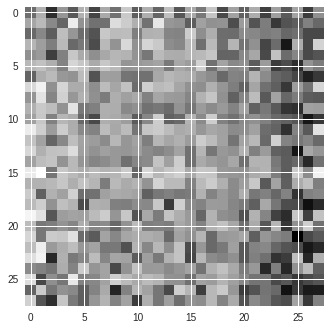

Epoch 775/1000... Discriminator Loss: 0.3389... Generator Loss: 4.3924


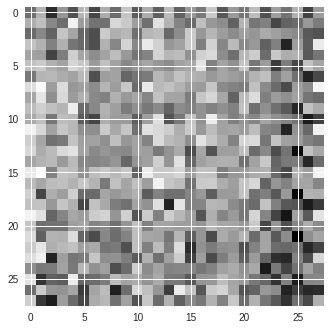

Epoch 780/1000... Discriminator Loss: 0.3368... Generator Loss: 4.5030


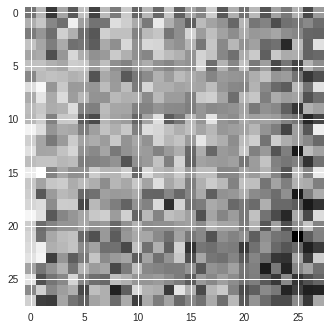

Epoch 785/1000... Discriminator Loss: 0.3362... Generator Loss: 4.5861


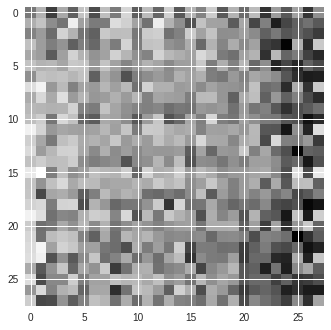

Epoch 790/1000... Discriminator Loss: 0.3362... Generator Loss: 4.5508


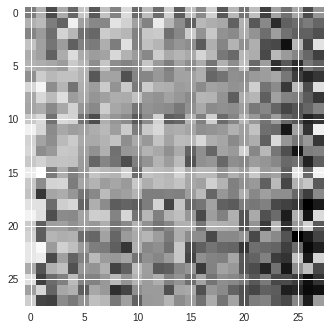

Epoch 795/1000... Discriminator Loss: 0.3365... Generator Loss: 4.6536


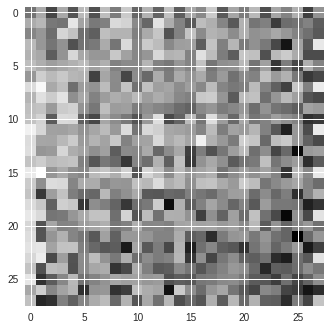

Epoch 800/1000... Discriminator Loss: 0.3695... Generator Loss: 4.6083


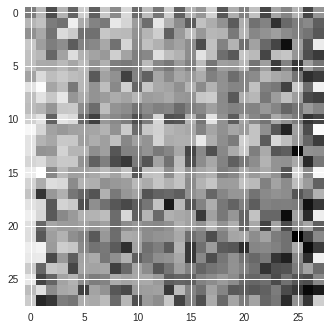

Epoch 805/1000... Discriminator Loss: 0.3429... Generator Loss: 4.4861


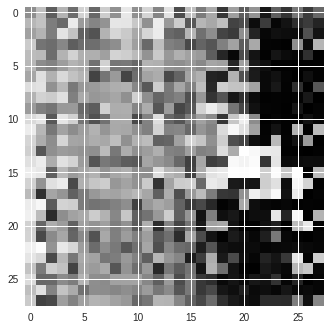

Epoch 810/1000... Discriminator Loss: 0.3368... Generator Loss: 4.5184


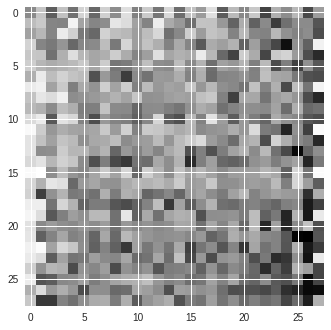

Epoch 815/1000... Discriminator Loss: 0.3360... Generator Loss: 4.5907


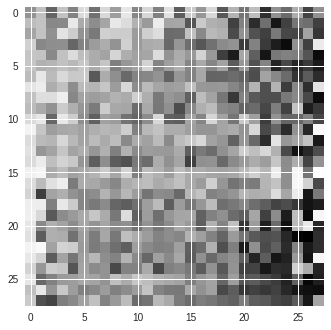

Epoch 820/1000... Discriminator Loss: 0.3357... Generator Loss: 4.6213


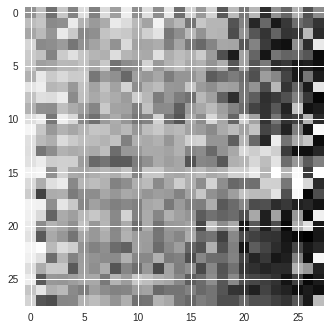

Epoch 825/1000... Discriminator Loss: 0.3353... Generator Loss: 4.6792


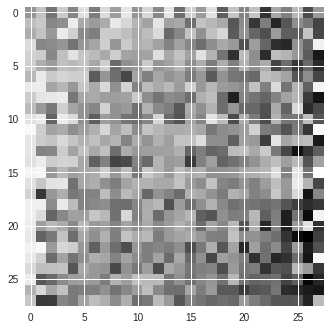

Epoch 830/1000... Discriminator Loss: 0.3348... Generator Loss: 4.6838


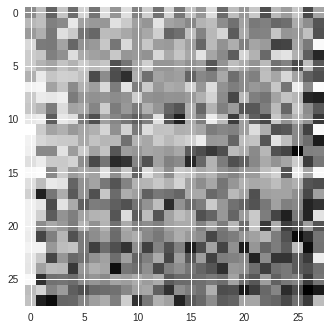

Epoch 835/1000... Discriminator Loss: 0.3367... Generator Loss: 4.7664


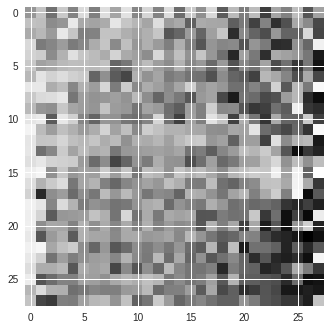

Epoch 840/1000... Discriminator Loss: 0.3398... Generator Loss: 4.6828


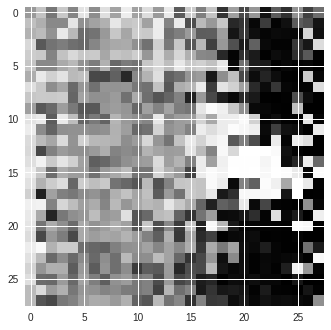

Epoch 845/1000... Discriminator Loss: 0.3345... Generator Loss: 4.7395


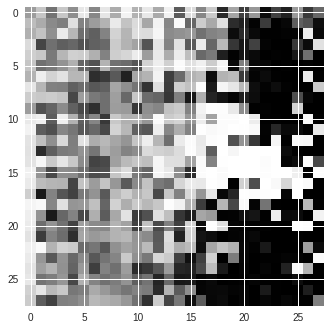

Epoch 850/1000... Discriminator Loss: 0.3339... Generator Loss: 4.7960


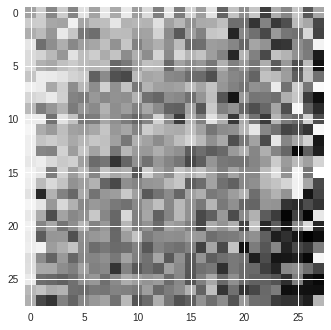

Epoch 855/1000... Discriminator Loss: 0.3350... Generator Loss: 4.8598


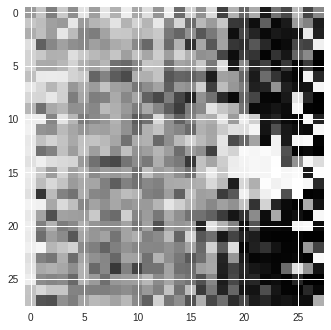

Epoch 860/1000... Discriminator Loss: 0.3389... Generator Loss: 4.8271


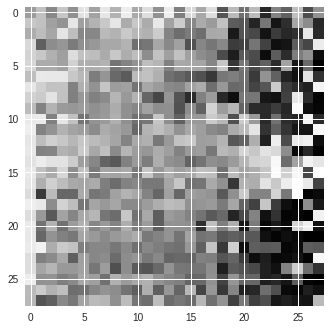

Epoch 865/1000... Discriminator Loss: 0.3335... Generator Loss: 4.8929


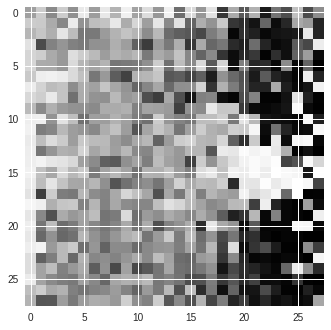

Epoch 870/1000... Discriminator Loss: 0.3332... Generator Loss: 4.8821


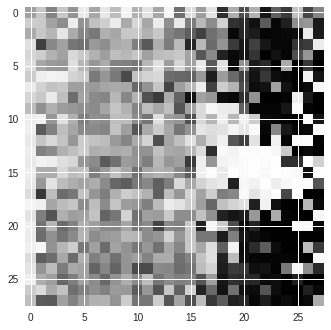

Epoch 875/1000... Discriminator Loss: 0.3345... Generator Loss: 4.8732


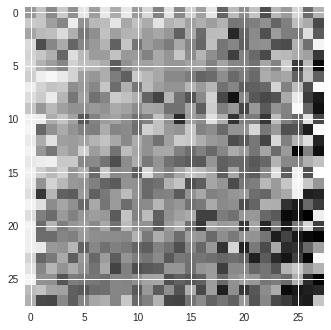

Epoch 880/1000... Discriminator Loss: 0.3393... Generator Loss: 4.8992


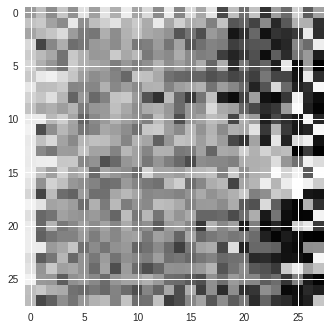

Epoch 885/1000... Discriminator Loss: 0.3337... Generator Loss: 4.8015


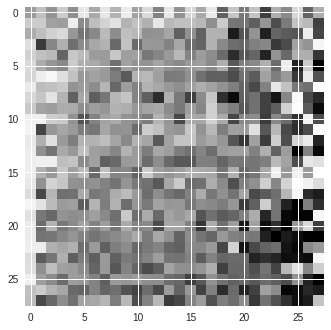

Epoch 890/1000... Discriminator Loss: 0.3333... Generator Loss: 4.8699


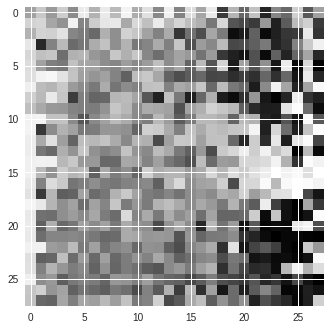

Epoch 895/1000... Discriminator Loss: 0.3335... Generator Loss: 4.9035


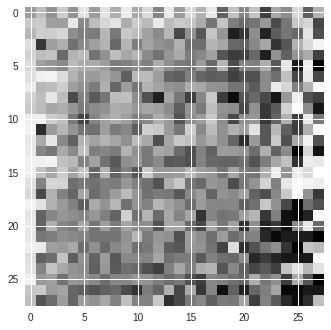

Epoch 900/1000... Discriminator Loss: 0.3376... Generator Loss: 4.8540


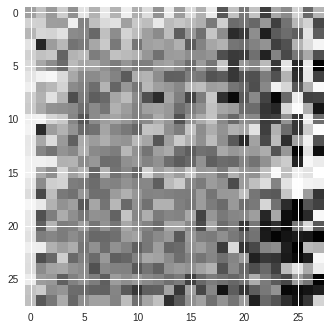

Epoch 905/1000... Discriminator Loss: 0.3340... Generator Loss: 4.9678


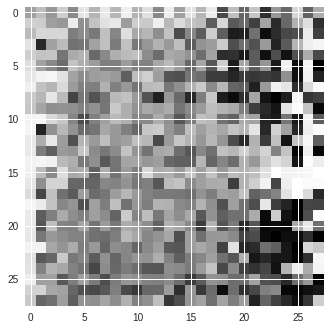

Epoch 910/1000... Discriminator Loss: 0.3341... Generator Loss: 4.9528


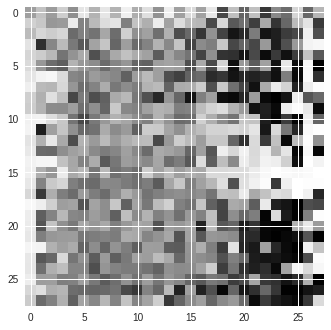

Epoch 915/1000... Discriminator Loss: 0.3352... Generator Loss: 4.9634


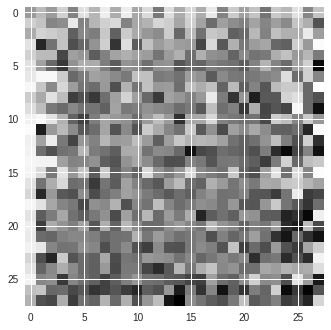

Epoch 920/1000... Discriminator Loss: 0.3352... Generator Loss: 4.9864


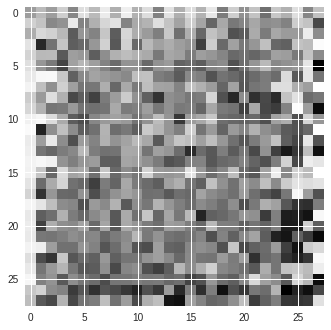

Epoch 925/1000... Discriminator Loss: 0.3333... Generator Loss: 4.9148


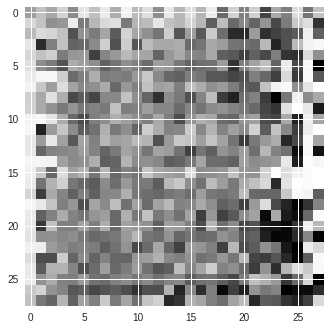

Epoch 930/1000... Discriminator Loss: 0.3340... Generator Loss: 5.0237


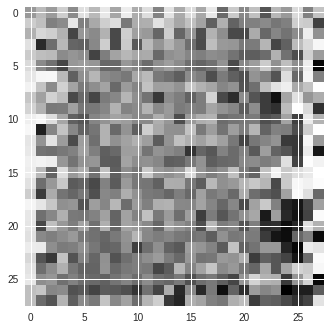

Epoch 935/1000... Discriminator Loss: 0.3376... Generator Loss: 5.0458


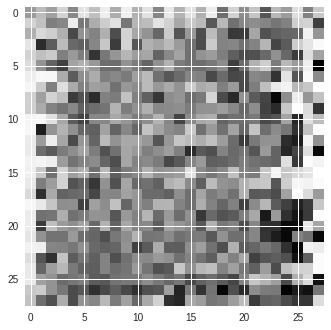

Epoch 940/1000... Discriminator Loss: 0.3348... Generator Loss: 4.9961


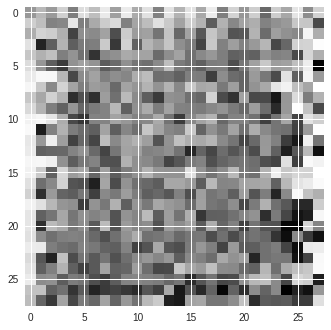

Epoch 945/1000... Discriminator Loss: 0.3324... Generator Loss: 4.9991


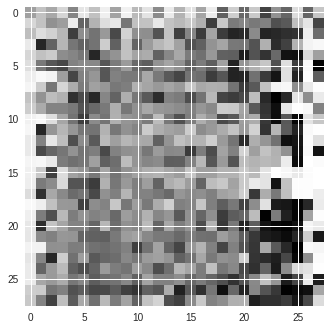

Epoch 950/1000... Discriminator Loss: 0.3316... Generator Loss: 5.1136


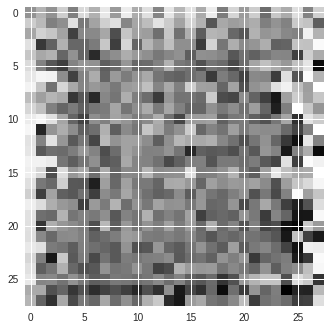

Epoch 955/1000... Discriminator Loss: 0.3321... Generator Loss: 5.0480


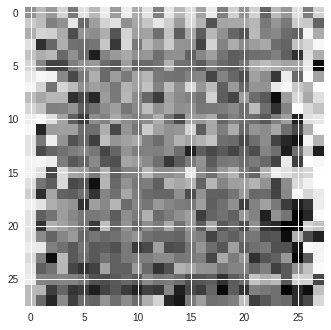

Epoch 960/1000... Discriminator Loss: 0.3328... Generator Loss: 5.1173


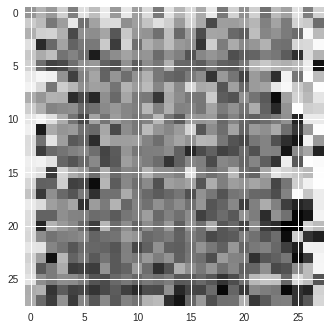

Epoch 965/1000... Discriminator Loss: 0.3362... Generator Loss: 5.1185


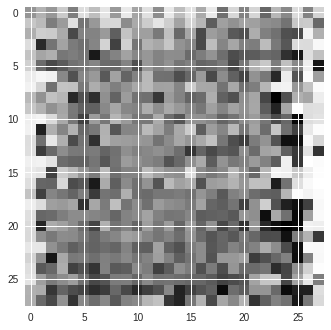

Epoch 970/1000... Discriminator Loss: 0.3324... Generator Loss: 5.1089


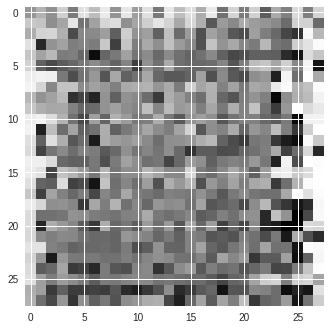

Epoch 975/1000... Discriminator Loss: 0.3323... Generator Loss: 5.1962


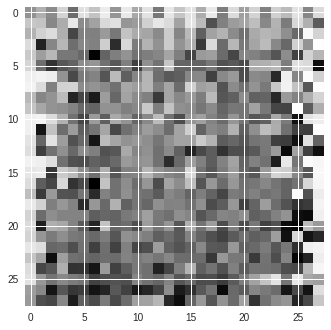

Epoch 980/1000... Discriminator Loss: 0.3336... Generator Loss: 5.2573


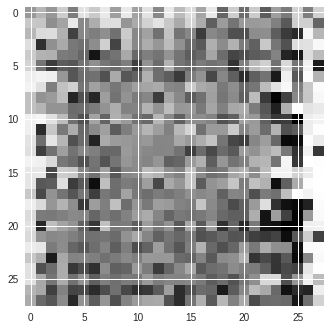

Epoch 985/1000... Discriminator Loss: 0.3348... Generator Loss: 5.2975


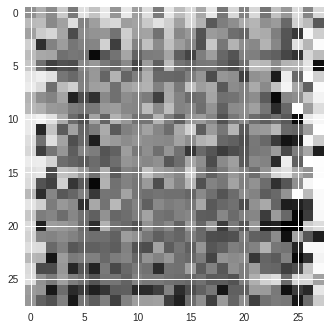

Epoch 990/1000... Discriminator Loss: 0.3310... Generator Loss: 5.3052


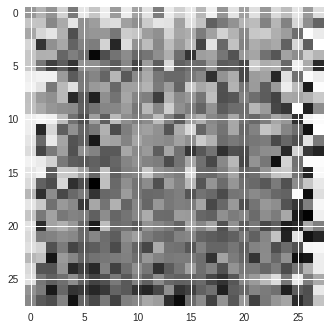

Epoch 995/1000... Discriminator Loss: 0.3315... Generator Loss: 5.2710


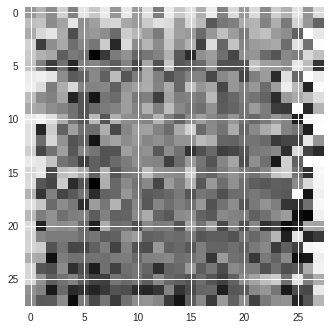

Epoch 1000/1000... Discriminator Loss: 0.3330... Generator Loss: 5.4258


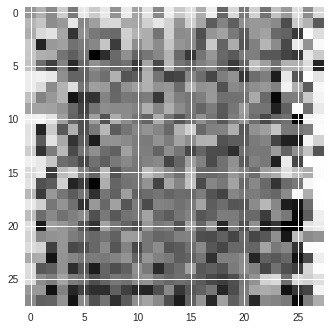

In [17]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
epochs = 1000m
shape = getInfo(T1_DCM)[1]

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches, shape)